In [1]:
import logging

import probtorch
import torch

import combinators
import foldable
import importance
import mcmc
import ssm
import trace_tries
import utils

In [2]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [3]:
mu = torch.zeros(1)
sigma = torch.ones(1) / 2
delta = torch.ones(1)
zs = torch.ones(50+1) * -1
zs[0] = 0

In [4]:
ssm_initializer = combinators.ReturnModel(zs[0], mu, sigma, delta)
ssm_step = foldable.Foldable(combinators.PrimitiveCall(ssm.ssm_step), initializer=ssm_initializer)
ssm_sequence = foldable.Reduce(ssm_step, generator=lambda: range(zs.shape[0]-1))

In [5]:
_, generative = ssm_sequence()

In [6]:
data = {k.rpartition('/')[-1]: rv.value for (k, rv) in generative.filter(lambda k, rv: 'X_' in k)}

In [7]:
particle_shape = (100,)

In [8]:
ssm_params = {
    'mu': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    },
    'sigma': {
        'loc': torch.tensor(1.),
        'scale': torch.tensor(0.25),
    },
    'delta': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    }
}

In [9]:
init_ssm_generative = combinators.HyperPopulation(ssm.init_ssm, particle_shape, hyper=ssm_params)
ssm_step_generative = foldable.Foldable(combinators.PrimitiveCall(ssm.ssm_step), initializer=init_ssm_generative)
ssm_generative = foldable.Reduce(ssm_step_generative, lambda: range(50))

In [10]:
init_ssm_proposal = combinators.HyperPopulation(ssm.init_ssm, particle_shape, trainable=ssm_params)
ssm_step_proposal = foldable.Foldable(combinators.PrimitiveCall(ssm.ssm_step), initializer=init_ssm_proposal)
ssm_proposal = foldable.Reduce(ssm_step_proposal, lambda: range(50))

In [11]:
ssm_training = combinators.score_under_proposal(ssm_proposal, ssm_generative)

In [12]:
inference, init_ssm_params, elbos = importance.variational_importance(
    ssm_training, 1000, data, use_cuda=False,
    lr=1e-2, patience=100
)

01/15/2019 14:33:22 ELBO=-4.88452393e+02 at epoch 1
01/15/2019 14:33:22 ELBO=-4.84363953e+02 at epoch 2
01/15/2019 14:33:22 ELBO=-3.76223602e+02 at epoch 3
01/15/2019 14:33:22 ELBO=-4.27854797e+02 at epoch 4
01/15/2019 14:33:22 ELBO=-2.20385910e+02 at epoch 5
01/15/2019 14:33:22 ELBO=-4.73153442e+02 at epoch 6
01/15/2019 14:33:22 ELBO=-2.66359070e+02 at epoch 7
01/15/2019 14:33:22 ELBO=-3.53112823e+02 at epoch 8
01/15/2019 14:33:22 ELBO=-4.66945099e+02 at epoch 9
01/15/2019 14:33:22 ELBO=-4.53490997e+02 at epoch 10
01/15/2019 14:33:22 ELBO=-4.12558258e+02 at epoch 11
01/15/2019 14:33:22 ELBO=-6.17007141e+02 at epoch 12
01/15/2019 14:33:22 ELBO=-3.33909912e+02 at epoch 13
01/15/2019 14:33:22 ELBO=-3.27168793e+02 at epoch 14
01/15/2019 14:33:22 ELBO=-4.41899475e+02 at epoch 15
01/15/2019 14:33:22 ELBO=-3.02044403e+02 at epoch 16
01/15/2019 14:33:23 ELBO=-4.14907318e+02 at epoch 17
01/15/2019 14:33:23 ELBO=-3.72693237e+02 at epoch 18
01/15/2019 14:33:23 ELBO=-3.34281799e+02 at epoch 19
01

Epoch   168: reducing learning rate of group 0 to 5.0000e-03.


01/15/2019 14:33:36 ELBO=-3.04734955e+02 at epoch 173
01/15/2019 14:33:36 ELBO=-2.99781281e+02 at epoch 174
01/15/2019 14:33:36 ELBO=-3.85253967e+02 at epoch 175
01/15/2019 14:33:36 ELBO=-5.02628296e+02 at epoch 176
01/15/2019 14:33:36 ELBO=-3.04712311e+02 at epoch 177
01/15/2019 14:33:36 ELBO=-5.02774933e+02 at epoch 178
01/15/2019 14:33:36 ELBO=-2.58278625e+02 at epoch 179
01/15/2019 14:33:36 ELBO=-4.75936401e+02 at epoch 180
01/15/2019 14:33:36 ELBO=-3.01357300e+02 at epoch 181
01/15/2019 14:33:36 ELBO=-4.79119629e+02 at epoch 182
01/15/2019 14:33:36 ELBO=-2.91089996e+02 at epoch 183
01/15/2019 14:33:36 ELBO=-3.65700439e+02 at epoch 184
01/15/2019 14:33:36 ELBO=-5.44997681e+02 at epoch 185
01/15/2019 14:33:36 ELBO=-4.73261230e+02 at epoch 186
01/15/2019 14:33:37 ELBO=-4.70753143e+02 at epoch 187
01/15/2019 14:33:37 ELBO=-3.23853149e+02 at epoch 188
01/15/2019 14:33:37 ELBO=-3.83759796e+02 at epoch 189
01/15/2019 14:33:37 ELBO=-2.58548279e+02 at epoch 190
01/15/2019 14:33:37 ELBO=-2.

Epoch   269: reducing learning rate of group 0 to 2.5000e-03.


01/15/2019 14:33:43 ELBO=-3.70352203e+02 at epoch 273
01/15/2019 14:33:43 ELBO=-3.97510559e+02 at epoch 274
01/15/2019 14:33:43 ELBO=-4.72628265e+02 at epoch 275
01/15/2019 14:33:43 ELBO=-3.55018982e+02 at epoch 276
01/15/2019 14:33:43 ELBO=-3.53008148e+02 at epoch 277
01/15/2019 14:33:44 ELBO=-4.23808441e+02 at epoch 278
01/15/2019 14:33:44 ELBO=-3.18560425e+02 at epoch 279
01/15/2019 14:33:44 ELBO=-5.26203369e+02 at epoch 280
01/15/2019 14:33:44 ELBO=-3.91010834e+02 at epoch 281
01/15/2019 14:33:44 ELBO=-3.28756653e+02 at epoch 282
01/15/2019 14:33:44 ELBO=-3.06821472e+02 at epoch 283
01/15/2019 14:33:44 ELBO=-3.25966217e+02 at epoch 284
01/15/2019 14:33:44 ELBO=-3.44084473e+02 at epoch 285
01/15/2019 14:33:44 ELBO=-3.70384827e+02 at epoch 286
01/15/2019 14:33:44 ELBO=-2.77722992e+02 at epoch 287
01/15/2019 14:33:44 ELBO=-2.45252319e+02 at epoch 288
01/15/2019 14:33:44 ELBO=-5.52767212e+02 at epoch 289
01/15/2019 14:33:44 ELBO=-3.89208618e+02 at epoch 290
01/15/2019 14:33:45 ELBO=-2.

Epoch   370: reducing learning rate of group 0 to 1.2500e-03.


01/15/2019 14:33:52 ELBO=-7.22291565e+02 at epoch 374
01/15/2019 14:33:52 ELBO=-3.04115479e+02 at epoch 375
01/15/2019 14:33:52 ELBO=-3.40481384e+02 at epoch 376
01/15/2019 14:33:52 ELBO=-3.48496155e+02 at epoch 377
01/15/2019 14:33:52 ELBO=-3.60798615e+02 at epoch 378
01/15/2019 14:33:52 ELBO=-5.20905212e+02 at epoch 379
01/15/2019 14:33:53 ELBO=-2.87286621e+02 at epoch 380
01/15/2019 14:33:53 ELBO=-2.77277954e+02 at epoch 381
01/15/2019 14:33:53 ELBO=-3.95966064e+02 at epoch 382
01/15/2019 14:33:53 ELBO=-2.30714203e+02 at epoch 383
01/15/2019 14:33:53 ELBO=-2.72145874e+02 at epoch 384
01/15/2019 14:33:53 ELBO=-2.62381683e+02 at epoch 385
01/15/2019 14:33:53 ELBO=-4.33088593e+02 at epoch 386
01/15/2019 14:33:53 ELBO=-2.72714539e+02 at epoch 387
01/15/2019 14:33:53 ELBO=-4.23104736e+02 at epoch 388
01/15/2019 14:33:53 ELBO=-4.36568726e+02 at epoch 389
01/15/2019 14:33:54 ELBO=-5.30527710e+02 at epoch 390
01/15/2019 14:33:54 ELBO=-3.44549652e+02 at epoch 391
01/15/2019 14:33:54 ELBO=-5.

Epoch   471: reducing learning rate of group 0 to 6.2500e-04.


01/15/2019 14:34:01 ELBO=-2.39926544e+02 at epoch 475
01/15/2019 14:34:01 ELBO=-4.41530914e+02 at epoch 476
01/15/2019 14:34:01 ELBO=-3.08529297e+02 at epoch 477
01/15/2019 14:34:01 ELBO=-5.69209045e+02 at epoch 478
01/15/2019 14:34:01 ELBO=-3.01344910e+02 at epoch 479
01/15/2019 14:34:01 ELBO=-4.73852844e+02 at epoch 480
01/15/2019 14:34:01 ELBO=-3.31878235e+02 at epoch 481
01/15/2019 14:34:02 ELBO=-3.67085724e+02 at epoch 482
01/15/2019 14:34:02 ELBO=-3.32607330e+02 at epoch 483
01/15/2019 14:34:02 ELBO=-3.87388123e+02 at epoch 484
01/15/2019 14:34:02 ELBO=-3.02044312e+02 at epoch 485
01/15/2019 14:34:02 ELBO=-2.70931152e+02 at epoch 486
01/15/2019 14:34:02 ELBO=-3.93798218e+02 at epoch 487
01/15/2019 14:34:02 ELBO=-3.21081940e+02 at epoch 488
01/15/2019 14:34:02 ELBO=-4.02828308e+02 at epoch 489
01/15/2019 14:34:02 ELBO=-5.50399841e+02 at epoch 490
01/15/2019 14:34:02 ELBO=-4.96849762e+02 at epoch 491
01/15/2019 14:34:02 ELBO=-4.02881409e+02 at epoch 492
01/15/2019 14:34:02 ELBO=-3.

Epoch   631: reducing learning rate of group 0 to 3.1250e-04.


01/15/2019 14:34:14 ELBO=-3.50027588e+02 at epoch 635
01/15/2019 14:34:14 ELBO=-3.93712555e+02 at epoch 636
01/15/2019 14:34:14 ELBO=-2.87206390e+02 at epoch 637
01/15/2019 14:34:15 ELBO=-3.56985931e+02 at epoch 638
01/15/2019 14:34:15 ELBO=-2.94242920e+02 at epoch 639
01/15/2019 14:34:15 ELBO=-3.22164948e+02 at epoch 640
01/15/2019 14:34:15 ELBO=-2.86351990e+02 at epoch 641
01/15/2019 14:34:15 ELBO=-4.27953827e+02 at epoch 642
01/15/2019 14:34:15 ELBO=-3.00100067e+02 at epoch 643
01/15/2019 14:34:15 ELBO=-4.03378693e+02 at epoch 644
01/15/2019 14:34:15 ELBO=-3.12345276e+02 at epoch 645
01/15/2019 14:34:15 ELBO=-2.83018951e+02 at epoch 646
01/15/2019 14:34:15 ELBO=-3.20729797e+02 at epoch 647
01/15/2019 14:34:15 ELBO=-5.74547546e+02 at epoch 648
01/15/2019 14:34:16 ELBO=-5.70397766e+02 at epoch 649
01/15/2019 14:34:16 ELBO=-2.51570038e+02 at epoch 650
01/15/2019 14:34:16 ELBO=-2.05219131e+02 at epoch 651
01/15/2019 14:34:16 ELBO=-3.00652588e+02 at epoch 652
01/15/2019 14:34:16 ELBO=-2.

Epoch   732: reducing learning rate of group 0 to 1.5625e-04.


01/15/2019 14:34:23 ELBO=-4.41976807e+02 at epoch 736
01/15/2019 14:34:23 ELBO=-3.25052795e+02 at epoch 737
01/15/2019 14:34:23 ELBO=-2.53182983e+02 at epoch 738
01/15/2019 14:34:23 ELBO=-3.43579407e+02 at epoch 739
01/15/2019 14:34:23 ELBO=-2.38241943e+02 at epoch 740
01/15/2019 14:34:23 ELBO=-6.19537964e+02 at epoch 741
01/15/2019 14:34:24 ELBO=-2.75842072e+02 at epoch 742
01/15/2019 14:34:24 ELBO=-2.39671326e+02 at epoch 743
01/15/2019 14:34:24 ELBO=-3.31972534e+02 at epoch 744
01/15/2019 14:34:24 ELBO=-3.92635315e+02 at epoch 745
01/15/2019 14:34:24 ELBO=-4.05855743e+02 at epoch 746
01/15/2019 14:34:24 ELBO=-2.66013611e+02 at epoch 747
01/15/2019 14:34:24 ELBO=-3.39539764e+02 at epoch 748
01/15/2019 14:34:24 ELBO=-3.04165161e+02 at epoch 749
01/15/2019 14:34:24 ELBO=-4.26262146e+02 at epoch 750
01/15/2019 14:34:24 ELBO=-3.96714172e+02 at epoch 751
01/15/2019 14:34:24 ELBO=-3.37251709e+02 at epoch 752
01/15/2019 14:34:24 ELBO=-2.68558777e+02 at epoch 753
01/15/2019 14:34:24 ELBO=-2.

Epoch   833: reducing learning rate of group 0 to 7.8125e-05.


01/15/2019 14:34:32 ELBO=-4.56726410e+02 at epoch 837
01/15/2019 14:34:32 ELBO=-2.43558868e+02 at epoch 838
01/15/2019 14:34:32 ELBO=-2.81254517e+02 at epoch 839
01/15/2019 14:34:32 ELBO=-4.40339722e+02 at epoch 840
01/15/2019 14:34:32 ELBO=-4.32668518e+02 at epoch 841
01/15/2019 14:34:32 ELBO=-3.86873047e+02 at epoch 842
01/15/2019 14:34:32 ELBO=-3.34425537e+02 at epoch 843
01/15/2019 14:34:32 ELBO=-3.52658630e+02 at epoch 844
01/15/2019 14:34:32 ELBO=-2.53978394e+02 at epoch 845
01/15/2019 14:34:32 ELBO=-3.40688904e+02 at epoch 846
01/15/2019 14:34:32 ELBO=-2.83264954e+02 at epoch 847
01/15/2019 14:34:33 ELBO=-3.67041138e+02 at epoch 848
01/15/2019 14:34:33 ELBO=-2.56364532e+02 at epoch 849
01/15/2019 14:34:33 ELBO=-5.05163727e+02 at epoch 850
01/15/2019 14:34:33 ELBO=-4.53706299e+02 at epoch 851
01/15/2019 14:34:33 ELBO=-2.61499115e+02 at epoch 852
01/15/2019 14:34:33 ELBO=-2.37807205e+02 at epoch 853
01/15/2019 14:34:33 ELBO=-3.24018524e+02 at epoch 854
01/15/2019 14:34:33 ELBO=-3.

Epoch   934: reducing learning rate of group 0 to 3.9063e-05.


01/15/2019 14:34:41 ELBO=-3.26523743e+02 at epoch 938
01/15/2019 14:34:41 ELBO=-3.79746613e+02 at epoch 939
01/15/2019 14:34:41 ELBO=-3.53933167e+02 at epoch 940
01/15/2019 14:34:41 ELBO=-4.73799377e+02 at epoch 941
01/15/2019 14:34:41 ELBO=-3.94771606e+02 at epoch 942
01/15/2019 14:34:41 ELBO=-2.68742310e+02 at epoch 943
01/15/2019 14:34:41 ELBO=-6.33966492e+02 at epoch 944
01/15/2019 14:34:42 ELBO=-3.98838593e+02 at epoch 945
01/15/2019 14:34:42 ELBO=-2.71815887e+02 at epoch 946
01/15/2019 14:34:42 ELBO=-4.04921143e+02 at epoch 947
01/15/2019 14:34:42 ELBO=-2.14801636e+02 at epoch 948
01/15/2019 14:34:42 ELBO=-4.04354065e+02 at epoch 949
01/15/2019 14:34:42 ELBO=-2.71474548e+02 at epoch 950
01/15/2019 14:34:42 ELBO=-2.65253326e+02 at epoch 951
01/15/2019 14:34:42 ELBO=-2.86855621e+02 at epoch 952
01/15/2019 14:34:42 ELBO=-4.45767181e+02 at epoch 953
01/15/2019 14:34:42 ELBO=-4.11603668e+02 at epoch 954
01/15/2019 14:34:42 ELBO=-2.28872040e+02 at epoch 955
01/15/2019 14:34:43 ELBO=-6.

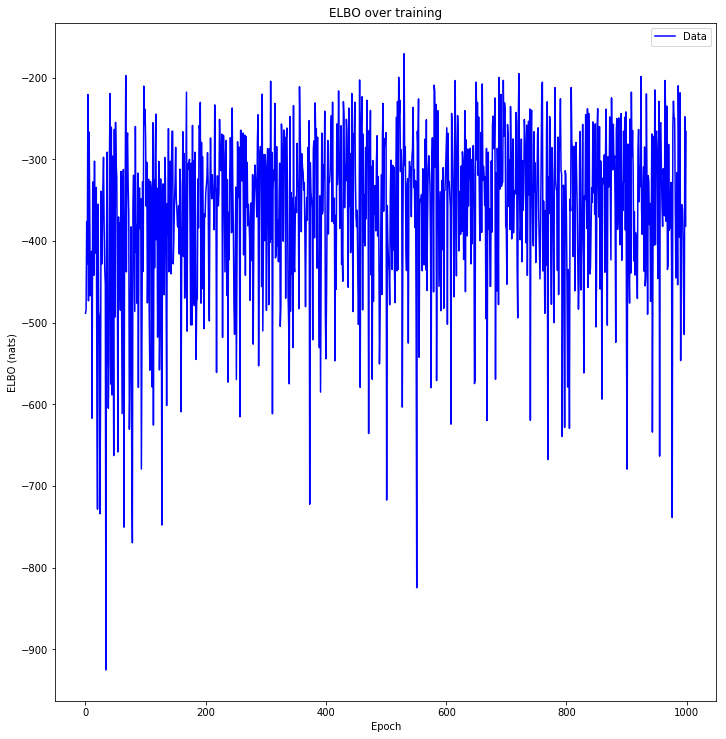

In [13]:
utils.plot_evidence_bounds(elbos)

In [14]:
ssm_smc = mcmc.reduce_resample_move_smc(combinators.PrimitiveCall(ssm.ssm_step), particle_shape, lambda: range(50), initializer=init_ssm_proposal, moves=10)
ssm_score = combinators.score_under_proposal(ssm_smc, ssm_generative)

In [15]:
_, inference = ssm_score(data=data)

In [16]:
for t in range(1, zs.shape[0]):
    key = generative.find(lambda k, v: ('Z_%d' % t) in k)[0]
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 1: 0.756534
SMC MSE at time 2: 0.571356
SMC MSE at time 3: 0.217805
SMC MSE at time 4: 0.663588
SMC MSE at time 5: 0.197100
SMC MSE at time 6: 0.327394
SMC MSE at time 7: 0.406699
SMC MSE at time 8: 3.882228
SMC MSE at time 9: 9.536229
SMC MSE at time 10: 5.749354
SMC MSE at time 11: 2.263395
SMC MSE at time 12: 3.054619
SMC MSE at time 13: 2.264088
SMC MSE at time 14: 0.370000
SMC MSE at time 15: 1.684971
SMC MSE at time 16: 0.529520
SMC MSE at time 17: 0.342175
SMC MSE at time 18: 1.194443
SMC MSE at time 19: 0.551441
SMC MSE at time 20: 0.226900
SMC MSE at time 21: 1.456649
SMC MSE at time 22: 1.223960
SMC MSE at time 23: 0.111924
SMC MSE at time 24: 0.886784
SMC MSE at time 25: 0.481333
SMC MSE at time 26: 1.051815
SMC MSE at time 27: 5.478434
SMC MSE at time 28: 0.866075
SMC MSE at time 29: 6.447890
SMC MSE at time 30: 9.594846
SMC MSE at time 31: 9.297490
SMC MSE at time 32: 7.220005
SMC MSE at time 33: 3.056501
SMC MSE at time 34: 0.825448
SMC MSE at time 35: 0.7

In [17]:
init_ssm_params

"{'first.folder._initializer.delta__loc': 'tensor(1.00000e-02 *\n       3.2951)', 'first.folder._initializer.delta__scale': 'tensor(0.1635)', 'first.folder._initializer.mu__loc': 'tensor(-0.8038)', 'first.folder._initializer.mu__scale': 'tensor(-0.1234)', 'first.folder._initializer.sigma__loc': 'tensor(0.3478)', 'first.folder._initializer.sigma__scale': 'tensor(-0.2818)', 'second.sampler.folder._initializer.delta__loc': 'tensor(0.)', 'second.sampler.folder._initializer.delta__scale': 'tensor(0.2500)', 'second.sampler.folder._initializer.mu__loc': 'tensor(0.)', 'second.sampler.folder._initializer.mu__scale': 'tensor(0.2500)', 'second.sampler.folder._initializer.sigma__loc': 'tensor(1.)', 'second.sampler.folder._initializer.sigma__scale': 'tensor(0.2500)'}"